# Regressão espacial - Seguro rural


Regressão nos dá uma ferramenta para analizarmos como a estrutura espacial pode nos ajudar a entendermos nossos dados. Geralmente a estrutura espacial contribui para a modelagem de duas formas: 

1. O espaço pode ter impacto nos dados o processo gerador dos dados é esplicitamente espacial. (ex.: preços de casas). $\rightarrow$ **Aqui a geografia é uma variável e contribui diretamente para o modelo.**
2. Uma alternativa é utilizar a localização espacial como uma variável instrumental. Utilizar a localização geografica nos diagnósticos dos erros pode ser uma boa maneira de entender as estruturas implicitas nos dados. (ex.: se descobrimos que o erro é maior em algumas áreas do que em outras) $\rightarrow$ **A localização geográcifa é uma variável instrumental**

Uma estrutura espacial nos erros pode surgir quando a localização geográfica *deve ser*, de alguma forma, um atributo mas não conseguimos incuir no modelo. Além disso, um padrão na distribuição espacial nos erros pode surgir pela omissão de variáveis, ou por interações e interdependências complexas entre as variáveis explicativas. 

A maioria das variáveis utilizadas em ciências sociais contém informação espacial intrinseca. Dessa forma, o processo gerador dos dados sendo ou não explicitamente geográfico, adicionar informação sobre a relação espacial entre as variáveis pode melhorar nossos modelos. 


## Bibliotecas

In [6]:
!pip install geopandas==0.8.2
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda
#!pip install pysal

     |████████████████████████████████| 962 kB 1.4 MB/s eta 0:00:01
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.8.1
    Uninstalling geopandas-0.8.1:
      Successfully uninstalled geopandas-0.8.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pysal 2.4.0 requires libpysal>=4.4.0, but you'll have libpysal 4.3.0 which is incompatible.
pysal 2.4.0 requires mapclassify>=2.4.2, but you'll have mapclassify 2.3.0 which is incompatible.
pysal 2.4.0 requires urllib3>=1.26, but you'll have urllib3 1.25.11 which is incompatible.
Requirement already up-to-date: pyshp in /home/walef/anaconda3/lib/python3.8/site-packages (2.1.3)
Requirement already up-to-date: descartes in /home/walef/anaconda3/lib/python3.8/site-package

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as sm

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# Para regressão espacial
from pysal.model import spreg 
import pysal as ps

/home/walef/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


## Dados

In [5]:
link = 'https://raw.githubusercontent.com/walefmachado/spreg_rural_insurance/main/dados/'

### Dados de seguro rural

In [6]:
df_seg = pd.read_csv(link+'/dados_06_19.csv')

In [7]:
df_seg = df_seg[df_seg['ano']==2010]
df_seg = df_seg.drop(['ano', 'nome_mun', 'nome_meso', 'uf'], axis=1)

### Dados socioeconômicos

In [8]:
df_atlas = pd.read_csv(link+'/atlas.csv')

In [9]:
df_atlas = df_atlas[['mun', 'rdpc', 'p_agro', 't_fund25m', 
                     't_super25m', 'e_anosestudo', 'pibpc']]

In [10]:
dados_br = df_atlas.merge(df_seg, on='mun', how='left')

### Dados para espacial 

In [11]:
cod = pd.read_csv(link+'/codigos-mun.csv')

In [12]:
br = geopandas.read_file(link+'/br.json')

In [13]:
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [14]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [15]:
dados_br = cod_dados.merge(dados_br, on='mun', how='left')

In [16]:
dados_br = dados_br.fillna(0)
#dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['rm'], axis = 1)

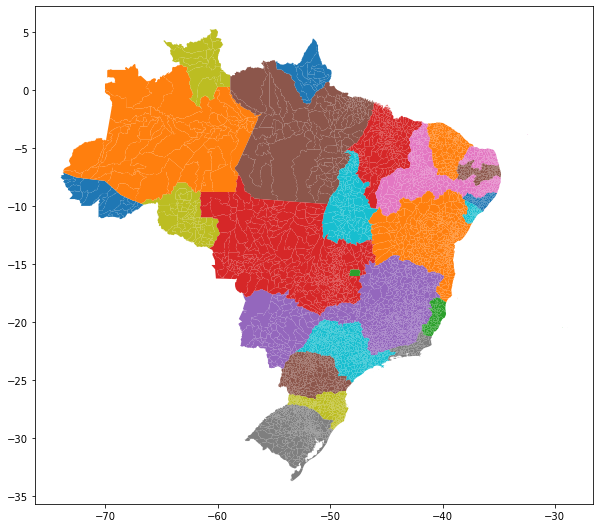

In [17]:
dados_br.plot(column='nome_uf', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

(-76.24537948479995,
 -26.57835135319995,
 -35.70232894754993,
 7.2229920305500315)

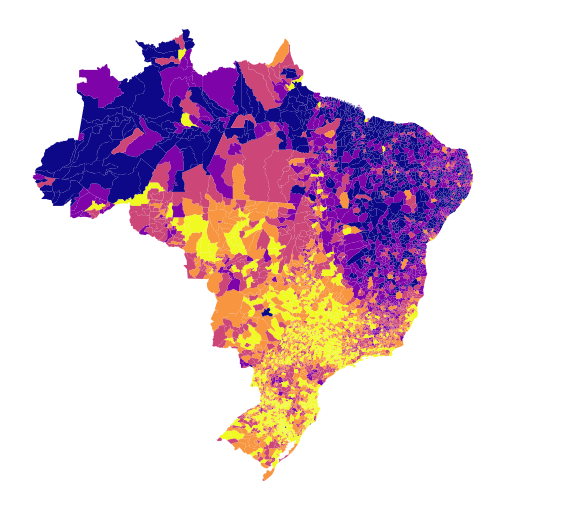

In [51]:
dados_br.plot(column='rdpc', figsize=(10, 10), cmap='plasma', scheme='quantiles');
plt.axis('off')

In [52]:
dados_br['centroid'] = dados_br.geometry.centroid

<ipython-input-52-201c7e449937>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dados_br['centroid'] = dados_br.geometry.centroid


(-76.24537948479994,
 -26.578351353199935,
 -35.70232894754993,
 7.2229920305500315)

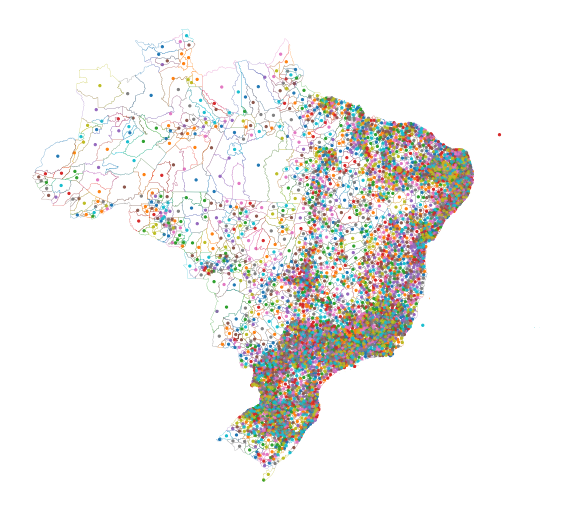

In [53]:
# Plot centroids
ax = dados_br.set_geometry('centroid').plot('nome_mun', markersize=5, figsize=(10, 10))
dados_br.plot('nome_mun', ax=ax, facecolor='none', edgecolor='k', linewidth=.2);
ax.axis('off')

## Sul

In [54]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
dados_sul = dados_sul.merge(dados_br, how='left')
dados_sul = dados_sul.fillna(0)

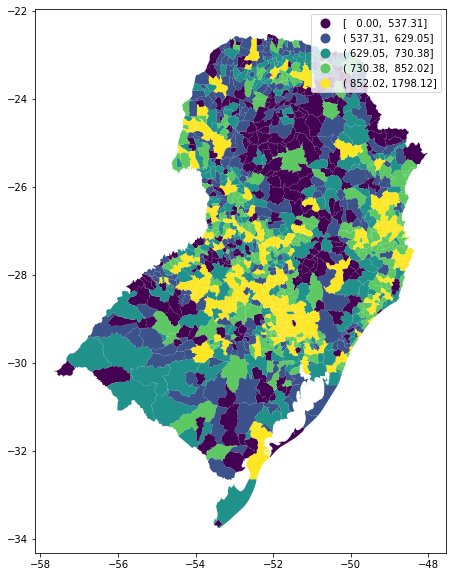

In [55]:
dados_sul.plot(column='rdpc', figsize=(10, 10), scheme='quantiles', legend=True); # , cmap='OrRd'

### Mapa das variáveis

In [56]:
variaveis = ['rdpc', 'p_agro', 't_fund25m', 't_super25m', 
             'e_anosestudo', 'pibpc', 'apolices_contratadas',
             'total_segurado_mil', 'valor_indenizacoes_pagas_mil',
             'apolices_indenizadas']

/home/walef/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:235: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/home/walef/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/home/walef/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:235: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/home/walef/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


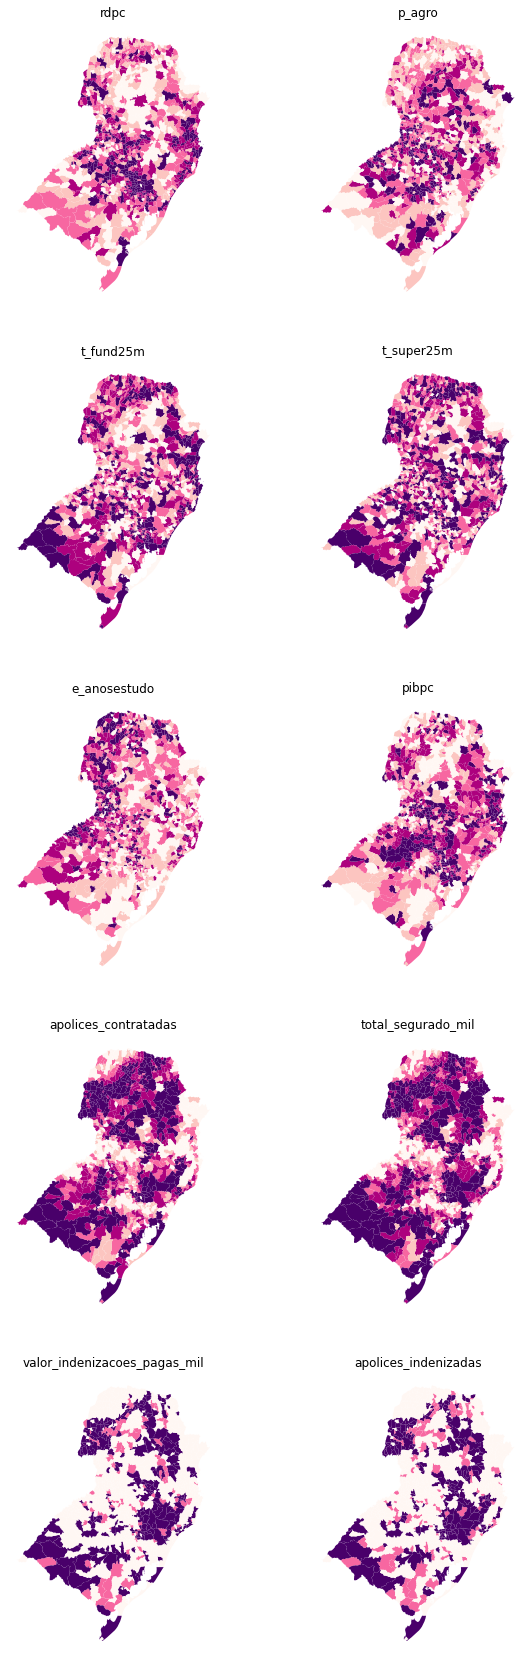

In [57]:
f, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 30))
axs = axs.flatten()
for i, col in enumerate(variaveis):
    ax = axs[i]
    dados_sul.plot(column=col, ax=ax, scheme='Quantiles', 
            linewidth=0, cmap='RdPu')
    ax.set_axis_off()
    ax.set_title(col)
plt.show();

### Autocorrelação espacial 

In [58]:
w = Queen.from_dataframe(dados_sul)

In [66]:
np.random.seed(123456)
mi_results = [Moran(dados_sul[variable], w) for variable in variaveis]
table = pd.DataFrame([(variable, res.I, res.p_sim) \
                          for variable,res \
                          in zip(variaveis, mi_results)
                         ], columns=['Variável', "I", 'valor-p']
                        )\
              .set_index('Variável')
table

,I,valor-p
Variável,,
rdpc,0.416840,0.001
p_agro,0.420238,0.001
t_fund25m,0.316688,0.001
t_super25m,0.107424,0.001
e_anosestudo,0.187569,0.001
pibpc,0.073822,0.003
apolices_contratadas,0.415592,0.001
total_segurado_mil,0.346790,0.001
valor_indenizacoes_pagas_mil,0.170531,0.001


## Regressão não espacial 

In [67]:
variaveis = ['rdpc', 'p_agro', 't_fund25m', 't_super25m', 
             'e_anosestudo', 'pibpc', 'total_segurado_mil', 
             'valor_indenizacoes_pagas_mil', 'apolices_indenizadas']

In [69]:
m1 = spreg.OLS(dados_sul[['apolices_contratadas']].values, dados_sul[variaveis].values,
                name_y='apolices_contratadas', name_x=variaveis)

In [70]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :apolices_contratadas                Number of Observations:        1191
Mean dependent var  :     30.5684                Number of Variables   :          10
S.D. dependent var  :     73.3478                Degrees of Freedom    :        1181
R-squared           :      0.7914
Adjusted R-squared  :      0.7898
Sum squared residual: 1335302.491                F-statistic           :    497.9208
Sigma-square        :    1130.654                Prob(F-statistic)     :           0
S.E. of regression  :      33.625                Log likelihood        :   -5871.628
Sigma-square ML     :    1121.161                Akaike info criterion :   11763.256
S.E of regression ML:     33.4837                Schwarz criterion     :   11814.082

---------------------------------------------------------------------

Nós podemos estar interessados na distribuição completa dos resíduos do modelo dentro de cada mesorregião. 

Para tornar isso mais claro, primeiro classificaremos os dados pela mediana do resíduo em cada mesorregião e, em seguida, faremos um box plot, que mostra a distribuição dos resíduos em cada mesorregião: 

In [ ]:
dados_sul['residual'] = m1.u
medians = dados_sul.groupby("nome_meso").residual.median().to_frame('hood_residual')

f = plt.figure(figsize=(15,7))
ax = plt.gca()
sns.boxplot('nome_meso', 'residual', ax = ax,
                data=dados_sul.merge(medians, how='left',
                              left_on='nome_meso',
                              right_index=True)
                   .sort_values('hood_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

Uma maneira bem simples de olhar para essa estrutura é examinando a relação entre os resíduos de uma observação e seus resíduos circundantes. 

Para fazer isso, usaremos pesos espaciais para representar as relações geográficas entre as observações.

In [75]:
# knn = weights.KNN.from_dataframe(dados_sul, k=1) # K vizinhos mais próximos

/home/walef/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 303 disconnected components.
  warnings.warn(message)


/home/walef/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


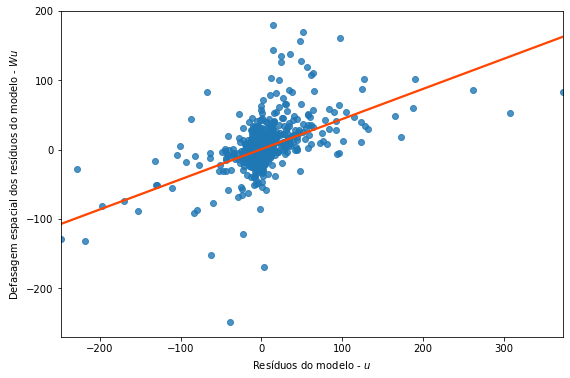

In [85]:
ax = plt.figure(figsize=(9,6))
lag_residual = weights.spatial_lag.lag_spatial(w, m1.u)
ax = sns.regplot(m1.u.flatten(), lag_residual.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('Resíduos do modelo - $u$')
ax.set_ylabel('Defasagem espacial dos resíduos do modelo - $W u$');

Neste gráfico, vemos que nossos erros de previsão tendem a se agrupar! É possível ver a relação entre nosso erro de previsão em cada mesorregião e o erro de previsão nas mesorregiões  vizinhas a ela. 

Isso significa que, quando o modelo tende a superestimar o número de apólices contratadas em uma mesoregião, é mais provável que o número de contrataçẽs nas mesorregiões no entorno também sejam superestimados. 

Utilizando a estatística **I de Moran local**, podemos identificar certas áreas onde nossas previsões do número de apólices contratadas tendem a ser significativamente "diferente"

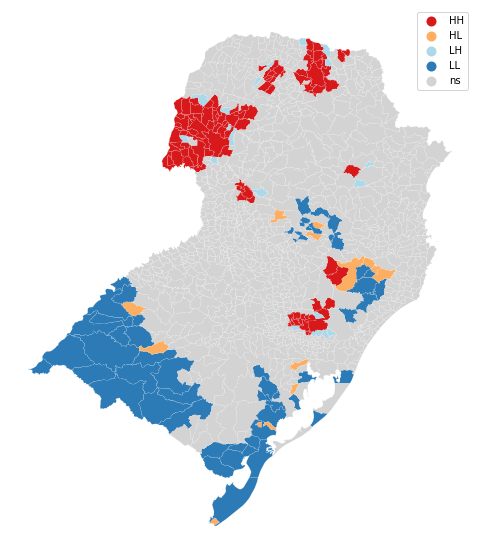

In [265]:
outliers = Moran_Local(m1.u, w, permutations=9999)
lisa_cluster(outliers, dados_sul, p=0.05, figsize = (10,10));

Assim, essas áreas tendem a ser locais onde nosso modelo significativamente subestima o preço noturno do airbnb para aquela observação específica e observações em seu entorno imediato.

Isso é crítico, pois, se pudermos identificar como essas áreas estão estruturadas - se elas tiverem uma geografia consistente que possamos modelar - então podemos melhorar nossas, ou pelo menos não prever as contratações com erros distribuidos de forma sistemática em algumas áreas enquanto prevemos corretamente preços em outras áreas.

Uma vez que predições significativas e insuficientes parecem se agrupar de uma forma altamente estruturada, podemos ser capazes de usar um modelo melhor para corrigir a geografia dos erros do nosso modelo. 

## Trazendo espaço para a estrutura de regressão 


Usar informações geográficas para “construir” novos dados é uma abordagem comum para trazer informações espaciais para a análise econometrica. Freqüentemente, isso reflete o fato de que os processos não são os mesmos em todos os lugares do mapa ou que as informações geográficas podem ser úteis para prever nosso resultado de interesse 

In [39]:
dados_sul.columns

Index(['cod_uf', 'nome_uf', 'mun', 'nome_mun', 'rm', 'meso', 'nome_meso',
       'micro', 'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry',
       'rdpc', 'p_agro', 't_fund25m', 't_super25m', 'e_anosestudo', 'pibpc',
       'apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil',
       'total_subvencao_mil', 'valor_indenizacoes_pagas_mil',
       'sinistralidade_media', 'taxa_media', 'apolices_indenizadas',
       'residual'],
      dtype='object')

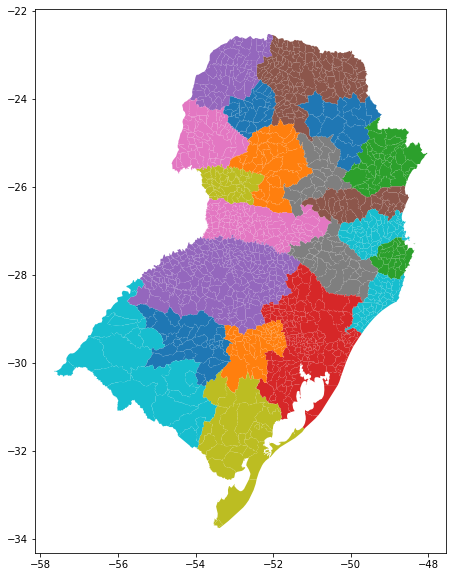

In [40]:
dados_sul.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd'

### Heterogeineidade espacial

Para ilustrar os efeitos fixos espaciais, vamos considerar o exemplo seção anterior para apresentar uma ilustração mais geral para “espaço como um proxy”. 

Podemos controlar os fatores não observados usando variáveis *dummy* tradicionais, mas baseando sua criação em uma regra espacial. Por exemplo, vamos incluir uma variável binária para cada mesorregião. Matematicamente, agora estamos ajustando a seguinte equação: 

$$y_i = \alpha_r + \displaystyle\sum_{k}X_{ik} \beta_k +\varepsilon_i$$

onde a principal diferença é que agora estamos permitindo que o termo constante, $\alpha$, varie por mesorregião $r$, $\alpha_r$. 

In [248]:
f = 'apolices_contratadas ~ ' + ' + '.join(variaveis) + ' + nome_meso - 1'
print(f)

apolices_contratadas ~ rdpc + p_agro + t_fund25m + t_super25m + e_anosestudo + pibpc + total_segurado_mil + valor_indenizacoes_pagas_mil + apolices_indenizadas + nome_meso - 1


Observe que o termo $-1$ à direita significa que estamos ajustando este modelo sem um termo de intercepto. Isso é necessário, uma vez que incluir um termo de intercepto ao lado médias para cada mesorregião tornaria o sistema de equações subjacente mal especificado. 

Usando esta expressão, podemos estimar os efeitos únicos de cada mesorregião, ajustando-se o  modelo:

In [249]:
m2 = sm.ols(f, data=dados_sul).fit()
print(m2.summary2())

                               Results: Ordinary least squares
Model:                       OLS                         Adj. R-squared:            0.847     
Dependent Variable:          apolices_contratadas        AIC:                       11408.9458
Date:                        2021-05-01 17:46            BIC:                       11571.5873
No. Observations:            1191                        Log-Likelihood:            -5672.5   
Df Model:                    31                          F-statistic:               213.1     
Df Residuals:                1159                        Prob (F-statistic):        0.00      
R-squared:                   0.851                       Scale:                     824.62    
----------------------------------------------------------------------------------------------
                                           Coef.   Std.Err.    t     P>|t|    [0.025   0.975] 
----------------------------------------------------------------------------------

A abordagem acima mostra como os efeitos fixos espaciais são um caso particular de uma regressão linear com uma variável categórica. A associação das mesorregiões é modelada usando variáveis binárias dummy. 

In [253]:
neighborhood_effects = m2.params.filter(like='nome_meso')
stripped = neighborhood_effects.index.str.strip('nome_meso[').str.strip(']')
neighborhood_effects.index = stripped
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
neighborhood_effects.head()

,fixed_effect
Centro Ocidental Paranaense,23.860590
Centro Ocidental Rio-grandense,-3.560001
Centro Oriental Paranaense,9.173783
Centro Oriental Rio-grandense,-3.822854
Centro-Sul Paranaense,5.588394


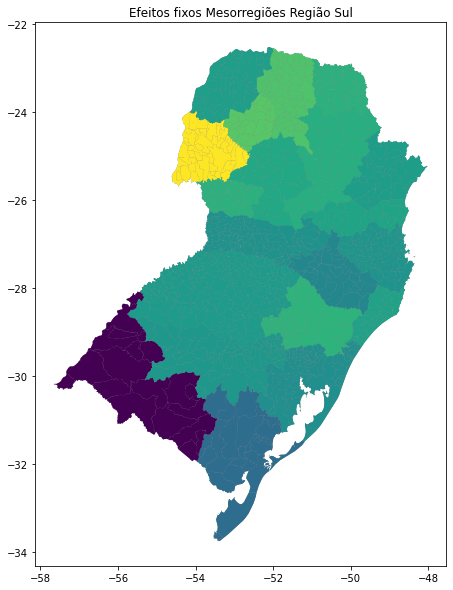

In [267]:
ax = dados_sul.plot(color='k', 
                        alpha=0.5,
                        figsize=(10,10))
dados_sul.merge(neighborhood_effects, how='left',
                    left_on='nome_meso', 
                    right_index=True)\
                  .dropna(subset=['fixed_effect'])\
                  .plot('fixed_effect',
                        ax=ax)
ax.set_title("Efeitos fixos Mesorregiões Região Sul")
plt.show()

Econometricamente falando, o que os efeitos fixos de cada mesorregião que introduzimos implicam é que, em vez de comparar todos os números de contratação de seguro como iguais, derivamos apenas a variação de cada mesorregião. Lembre-se de que a interpretação de $\beta_k$ é o efeito da variável $k$, dado que todas as outras variáveis explicativas incluídas permanecem constantes. 

Ao incluir uma única variável para cada área, estamos efetivamente forçando o modelo a comparar como iguais apenas o número de apólices contratadas que compartilham o mesmo valor para cada variável; ou, em outras palavras, apenas apólices contratadas na mesma mesorregião.

A introdução de efeitos fixos permite um maior grau de isolamento dos efeitos das variáveis que introduzimos no modelo porque podemos controlar os efeitos não observados que se alinham espacialmente com a distribuição do efeito fixo introduzido (por por mesorregião, no nosso caso).

In [ ]:
ax = plt.figure(figsize=(9,6))
lag_residual = weights.spatial_lag.lag_spatial(w, m2.u)
ax = sns.regplot(m2.u.flatten(), lag_residual.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('Resíduos do modelo - $u$')
ax.set_ylabel('Defasagem espacial dos resíduos do modelo - $W u$');

In [132]:
m3 = spreg.OLS(dados_sul[['apolices_contratadas']].values, dados_sul[variaveis].values,
                name_y='apolices_contratadas', name_x=variaveis, w=w, spat_diag=True)

In [133]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :apolices_contratadas                Number of Observations:        1191
Mean dependent var  :     30.5684                Number of Variables   :          10
S.D. dependent var  :     73.3478                Degrees of Freedom    :        1181
R-squared           :      0.7914
Adjusted R-squared  :      0.7898
Sum squared residual: 1335302.491                F-statistic           :    497.9208
Sigma-square        :    1130.654                Prob(F-statistic)     :           0
S.E. of regression  :      33.625                Log likelihood        :   -5871.628
Sigma-square ML     :    1121.161                Akaike info criterion :   11763.256
S.E of regression ML:     33.4837                Schwarz criterion     :   11814.082

---------------------------------------------------------------------

Incluir os pesos espaciais na regressão nos dá uma informação extra: o *summary* fornece o diagnóstico de dependência espacial. Trata-se de uma série de estatísticas que testam se os resíduos da regressão estão espacialmente correlacionados, a hipótese nula é a de uma distribuição aleatória no espaço. Se a hipótese nula for rejeitada, um pressuposto-chave do estimador de mínimos quadrados, independência do erro, é violado.

Dependendo da estrutura do padrão espacial, diferentes estratégias têm sido definidas na literatura de econometria espacial. Se você está interessado nisso, um recurso muito recente e bom para conferir é [Anselin & Rey (2015)](https://www.mdpi.com/2220-9964/4/2/815/pdf). 

O principal resultado do diagnóstico de dependência espacial é que há evidências claras para rejeitar a hipótese nula de aleatoriedade espacial nos resíduos, portanto, uma abordagem explicitamente espacial é recomendada.

## Modelo de defasagem espacial 
### (SAR – Spatial Auto Regressive)

$$y = \rho Wy + \varepsilon $$

$$\text{ou}$$

$$ y_i = \rho \sum_{j=1}^{n} w_{ij} y_j +  \varepsilon_i$$

In [138]:
#dados_sul["apol_lag"] = weights.spatial_lag.lag_spatial(w, dados_sul['apolices_contratadas'].values)

In [169]:
variaveis = ['apol_lag']

In [231]:
m4 = spreg.OLS(dados_sul[['apolices_contratadas']].values, 
               dados_sul[['apol_lag']].values, 
               name_y='apolices_contratadas',
               name_x=['apol_lag'], 
               w=w, 
               spat_diag=True)

In [232]:
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :apolices_contratadas                Number of Observations:        1191
Mean dependent var  :     30.5684                Number of Variables   :           2
S.D. dependent var  :     73.3478                Degrees of Freedom    :        1189
R-squared           :      0.2897
Adjusted R-squared  :      0.2891
Sum squared residual: 4547225.658                F-statistic           :    485.0060
Sigma-square        :    3824.412                Prob(F-statistic)     :   2.016e-90
S.E. of regression  :      61.842                Log likelihood        :   -6601.330
Sigma-square ML     :    3817.990                Akaike info criterion :   13206.659
S.E of regression ML:     61.7899                Schwarz criterion     :   13216.825

---------------------------------------------------------------------

## Modelo de defasagem espacial -- SAR

### Incluindo variáveis exógenas (SAR misto)

 $$y = \rho Wy + X\beta + \varepsilon $$ 
 
 $$\text{ou}$$
 
 $$ y_i = \rho \sum_{j=1}^{n} w_{ij} y_j + \sum_{j=1}^{p} x_{ij}\beta_j + \varepsilon_i$$

In [236]:
variaveis = ['rdpc', 'p_agro', 't_fund25m', 't_super25m', 
             'e_anosestudo', 'pibpc', 'total_segurado_mil', 
             'valor_indenizacoes_pagas_mil', 'apolices_indenizadas']

In [237]:
m5 = spreg.ML_Lag(dados_sul[['apolices_contratadas']].values, 
               dados_sul[variaveis].values, 
               name_y='apolices_contratadas',
               name_x=variaveis, 
               w=w)

In [238]:
print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :apolices_contratadas                Number of Observations:        1191
Mean dependent var  :     30.5684                Number of Variables   :          11
S.D. dependent var  :     73.3478                Degrees of Freedom    :        1180
Pseudo R-squared    :      0.8179
Spatial Pseudo R-squared:  0.7853
Sigma-square ML     :     978.731                Log likelihood        :   -5796.779
S.E of regression   :      31.285                Akaike info criterion :   11615.558
                                                 Schwarz criterion     :   11671.466

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------

In [239]:
m5.rho # Estimativa do coefciente auto regressivo.

0.2197661048652174

In [217]:
m5.betas # estimativas dos coeficientes

array([[-2.02378330e+01],
       [ 1.00535507e-02],
       [-2.08013821e-01],
       [-7.70130187e-01],
       [ 2.23123600e+00],
       [ 3.46977872e+00],
       [-3.71617127e-06],
       [ 6.70417228e-06],
       [-4.83075074e-05],
       [ 2.53863218e+00],
       [ 2.19766105e-01]])

## Modelo de erro auto-regressivo espacial 

### (SEM – Spatial Error Model)

$$y = X\beta+ \xi $$  
            
$$\xi = \lambda W \xi + \varepsilon$$

$$\text{ou}$$

$$ y_i = \sum_{j=1}^{p} x_{ij}\beta_j + \xi_i$$

$$ \xi_i = \lambda \sum_{j=1}^{n} w_{ij} u_j + \varepsilon$$

In [268]:
m6 = spreg.ML_Error(dados_sul[['apolices_contratadas']].values, 
               dados_sul[variaveis].values, 
               name_y='apolices_contratadas',
               name_x=variaveis, 
               w=w)

In [269]:
print(m6.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES
-------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :apolices_contratadas                Number of Observations:        1191
Mean dependent var  :     30.5684                Number of Variables   :          11
S.D. dependent var  :     73.3478                Degrees of Freedom    :        1180
Pseudo R-squared    :      0.7969
Spatial Pseudo R-squared:  0.7879

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT     -13.3612351      10.0765131      -1.3259780       0.1848470
                rdpc       0.0033572       0.0066702       0.5033056       0.6147494
              p_agro      -0.

In [242]:
m6.lam # estimativa do coeficiente autoregressivo espacial

0.5397611767549013

## Modelo de defasagem espacial com erro autorregressivo espacial 
### (SAC – Spatial autoregressive combined)

$$y = \rho W_1y +  X\beta+ \xi $$         
$$\xi = \lambda W_2 \xi + \varepsilon$$

$$\text{ou}$$ 

$$ y_i = \rho \sum_{j=1}^{n} w_{1_{ij}} y_i + \sum_{j=1}^{p} x_{ij}\beta_j + \xi_i$$ 

$$\xi_i = \lambda  \sum_{j=1}^{n} w_{2_{ij}} u_j + \varepsilon_1$$


In [277]:
m7 = spreg.GM_Combo(dados_sul[['apolices_contratadas']].values,
                    dados_sul[variaveis].values,
                    w=w,
                    name_y='apolices_contratadas', 
                    name_x=variaveis)

In [278]:
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES
-------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :apolices_contratadas                Number of Observations:        1191
Mean dependent var  :     30.5684                Number of Variables   :          11
S.D. dependent var  :     73.3478                Degrees of Freedom    :        1180
Pseudo R-squared    :      0.7969
Spatial Pseudo R-squared:  0.7879

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT     -13.3612351      10.0765131      -1.3259780       0.1848470
                rdpc       0.0033572       0.0066702       0.5033056       0.6147494
              p_agro      -0.

$$\text{THE END}$$